In [1]:
import torch

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric==2.4.0
!pip install torch_geometric_temporal -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 93.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 80.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.9 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 73.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━

In [2]:
!pip install torch_geometric==2.4.0

  Using cached torch_geometric-2.4.0-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)
  Attempting uninstall: torch_geometric
    Found existing installation: torch-geometric 2.7.0
    Uninstalling torch-geometric-2.7.0:
      Successfully uninstalled torch-geometric-2.7.0


In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
from geopy.distance import geodesic as GD
from shapely.geometry import Point, LineString
import networkx as nx
from torch_geometric.utils import to_dense_adj
from torch_geometric_temporal.signal import StaticGraphTemporalSignal, temporal_signal_split
from torch_geometric_temporal.nn.recurrent import A3TGCN, A3TGCN2

ModuleNotFoundError: No module named 'torch_geometric'

Already processed sensor data

In [16]:
sensor_data = pd.concat([pd.read_csv(f, delimiter = ';') for f in os.listdir() if f.endswith('.csv')], ignore_index=True)

In [17]:
sensor_cols = [col for col in sensor_data.columns if col not in ['Time', 'Name']]
sensor_data[sensor_cols] = sensor_data[sensor_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

sensor_data_cleaned = sensor_data.loc[~(sensor_data == 0).all(axis=1)]

In [18]:
sensor_data_slice = sensor_data_cleaned[['Name', 'Time', 'spd_proc']]
sensor_data_slice['Time'] = pd.to_datetime(sensor_data_slice['Time'], format='%d.%m.%Y %H:%M:%S')

C:\Windows\Temp\ipykernel_35272\1513374330.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data_slice['Time'] = pd.to_datetime(sensor_data_slice['Time'], format='%d.%m.%Y %H:%M:%S')


In [19]:
# Transform the data from 2018-01-01 00:00:00 -> 0, then next hour is 1 and etc if the first date be 2018-01-01 01:00:00
sensor_data_slice['Time'] = sensor_data_slice['Time'] - sensor_data_slice['Time'].min()
sensor_data_slice['Time'] = sensor_data_slice['Time'].dt.total_seconds() / 3600

C:\Windows\Temp\ipykernel_35272\149587949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data_slice['Time'] = sensor_data_slice['Time'] - sensor_data_slice['Time'].min()
C:\Windows\Temp\ipykernel_35272\149587949.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data_slice['Time'] = sensor_data_slice['Time'].dt.total_seconds() / 3600


In [20]:
sensor_data_slice['Name'] = sensor_data_slice['Name'].str.extract(r'(\d{3,4})')

C:\Windows\Temp\ipykernel_35272\3802126210.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sensor_data_slice['Name'] = sensor_data_slice['Name'].str.extract(r'(\d{3,4})')


In [21]:
sensor_positions = pd.read_excel("Sankryzos_koordinates.xlsx")
sensor_positions['Node'] = sensor_positions['Node'].str.extract('(\d+)')
for coord in ['x', 'y']:
    sensor_positions[coord] = pd.to_numeric(sensor_positions[coord].str.replace(',', '.').astype(float))

In [22]:
valid_sensors = set(sensor_data_slice['Name'].unique()) & set(sensor_positions['Node'])

In [23]:
sensor_data_slice = sensor_data_slice.loc[sensor_data_slice['Name'].isin(valid_sensors)]

In [24]:
#take the mean of spd_proc for each sensor that has the same id in each hour
sensor_data_slice = sensor_data_slice.groupby(['Name', 'Time']).mean().reset_index()

In [73]:
#convert the dataframe to a matrix with shape of [length of sequence * number of sensors]
sensor_data_matrix = sensor_data_slice.pivot(index='Time', columns='Name', values='spd_proc').sort_index()

In [74]:
sensor_positions = sensor_positions[sensor_positions['Node'].isin(valid_sensors)]
sensor_positions = sensor_positions.set_index('Node')

Old GeoDist calc

In [ ]:
#OLD CODE
#calculate the distances between all nodes and store them in a matrix where the i,j element is the distance between node i and node j
weighted_adj_matrix = np.zeros((len(sensor_positions), len(sensor_positions)))
for i in range(len(sensor_positions)):
    coords_i = (sensor_positions['y'][i], sensor_positions['x'][i])
    for j in range(len(sensor_positions)):
        coords_j = sensor_positions['y'][j], sensor_positions['x'][j]
        weighted_adj_matrix[i, j] = GD(coords_i, coords_j).km

Road Distance calculation with road network graph

In [ ]:
gdf_sensors = gpd.GeoDataFrame(
    sensor_positions,
    geometry=gpd.points_from_xy(sensor_positions.x, sensor_positions.y),
    crs='EPSG:4326'
)

gdf_sensors = gdf_sensors.to_crs(epsg=3346)

In [10]:
#Road Network build

roads = gpd.read_file('../../Keliai//keliai/keliai_gatves_ExportFeatures1.shp')

if roads.crs != "EPSG:3346":
    roads = roads.to_crs(epsg=3346)

In [17]:
roads

,vardas,tipas,data,metod,gyv_pavad,kategor,gyv_rej_kd,organizaci,gtv_id,numeris,...,gat_kodas2,bicycling,onewaybicy,reljefo_ko,ft_truckmi,tf_truckmi,shape_Leng,on,oneway,geometry
0,Birelių Sodų 2-oji g.,3.0,20021216.0,vo14,Vilniaus m.,9.0,31003.0,NTKRVI,50396.0,None,...,0,Y,None,0.0,0.0,0.0,178.429203,None,None,"LINESTRING (584902.28 6076630.778, 584929.061 ..."
1,Sakališkių g.,3.0,20100408.0,v52,Vilniaus m.,8.0,31003.0,HB,49694.0,None,...,0,Y,None,0.0,0.0,0.0,63.261350,None,None,"LINESTRING (584902.28 6076630.778, 584900.984 ..."
2,Birelių g.,3.0,20021216.0,vo14,Vilniaus m.,8.0,31003.0,NTKRVI,49124.0,None,...,0,Y,None,0.0,0.0,0.0,43.431850,None,None,"LINESTRING (585068.13 6077014.589, 585108.244 ..."
3,None,8.0,20200224.0,vo14,Vilniaus m.,10.0,31003.0,HB,0.0,None,...,0,Y,None,0.0,0.0,0.0,94.683172,None,None,"LINESTRING (585028.99 6077100.74, 585032.716 6..."
4,Birelių Sodų 5-oji g.,3.0,20021216.0,vo14,Vilniaus m.,9.0,31003.0,NTKRVI,50402.0,None,...,0,Y,None,0.0,0.0,0.0,242.177859,None,None,"LINESTRING (585274.258 6076996.091, 585406.059..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68502,None,9.0,20120703.0,vo14,Vilniaus m.,8.0,31003.0,HB,0.0,None,...,0,Y,None,0.0,0.0,0.0,14.631077,None,None,"LINESTRING (577773.051 6056905.997, 577787.675..."
68503,Naugarduko g.,3.0,20150319.0,v52,Vilniaus m.,7.0,31003.0,HB,22209.0,None,...,0,Y,F,0.0,0.0,0.0,9.069348,F,F,"LINESTRING (581139.285 6059965.482, 581133.215..."
68504,Naugarduko g.,3.0,20150319.0,v52,Vilniaus m.,7.0,31003.0,HB,22209.0,None,...,0,Y,F,0.0,0.0,0.0,9.164908,F,F,"LINESTRING (581140.375 6059952.093, 581146.743..."
68505,Antakalnio g.,3.0,20000120.0,v52,Vilniaus m.,7.0,31003.0,HB,21884.0,None,...,0,Y,F,0.0,0.0,0.0,11.284611,F,F,"LINESTRING (584724.946 6064720.344, 584723.09 ..."


In [16]:
roads['oneway'].value_counts(dropna=False)

oneway
None    54917
F        9209
N        4381
Name: count, dtype: int64

In [ ]:
#v2: Calculating distance between all nodes with API for road distance
#Build road network graph

G_roads = nx.Graph()

for idx, row in roads.iterrows():
    line = row.geometry  # Get the LINESTRING geometry
    coords = list(line.coords)  # Extract coordinates as a list of (x, y) tuples
    for i in range(len(coords) - 1):
        start = coords[i]  # Start point of the segment
        end = coords[i + 1]  # End point of the segment
        length = LineString([start, end]).length  # Length of the segment
        G_roads.add_edge(start, end, weight=length)  # Add edge with weight = length

In [ ]:
def find_nearest_node(graph, point):
    return min(graph.nodes, key=lambda x: Point(x).distance(point))

gdf_sensors["nearest_node"] = gdf_sensors.geometry.apply(lambda x: find_nearest_node(G_roads, x))

In [ ]:
n = len(gdf_sensors)

distance_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(n):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            start_node = gdf_sensors.iloc[i]["nearest_node"]
            end_node = gdf_sensors.iloc[j]["nearest_node"]
            try:
                shortest_path = nx.shortest_path_length(G_roads, start_node, end_node, weight="weight")

                #total_distance = sum(G_roads[shortest_path[k]][shortest_path[k + 1]]["weight"] for k in range(len(shortest_path) - 1))

                distance_matrix[i, j] = shortest_path / 1000

            except nx.NetworkXNoPath:
                distance_matrix[i, j] = np.inf
    print(f"Index {i} done")

Index 0 done
Index 1 done
Index 2 done
Index 3 done
Index 4 done
Index 5 done
Index 6 done
Index 7 done
Index 8 done
Index 9 done
Index 10 done
Index 11 done
Index 12 done
Index 13 done
Index 14 done
Index 15 done
Index 16 done
Index 17 done
Index 18 done
Index 19 done
Index 20 done
Index 21 done
Index 22 done
Index 23 done
Index 24 done
Index 25 done
Index 26 done
Index 27 done
Index 28 done
Index 29 done
Index 30 done
Index 31 done
Index 32 done
Index 33 done
Index 34 done
Index 35 done
Index 36 done
Index 37 done
Index 38 done
Index 39 done
Index 40 done
Index 41 done
Index 42 done
Index 43 done
Index 44 done
Index 45 done
Index 46 done
Index 47 done
Index 48 done
Index 49 done
Index 50 done
Index 51 done
Index 52 done
Index 53 done
Index 54 done
Index 55 done
Index 56 done
Index 57 done
Index 58 done
Index 59 done
Index 60 done
Index 61 done
Index 62 done
Index 63 done
Index 64 done
Index 65 done
Index 66 done
Index 67 done
Index 68 done
Index 69 done
Index 70 done
Index 71 done
In

In [ ]:
np.savetxt("distance_matrix_roads.csv", distance_matrix, delimiter=",")

In [ ]:
gdf_sensors

,x,y,geometry,nearest_node
Node,,,,
1001,25.286866,54.698668,POINT (582948.983 6063233.36),"(582949.6808695178, 6063234.294189271)"
1002,25.300914,54.697964,POINT (583855.892 6063171.705),"(583857.1886180108, 6063168.980500255)"
1003,25.308601,54.685154,POINT (584377.936 6061755.342),"(584380.1250116332, 6061753.190019483)"
1004,25.301221,54.677212,POINT (583918.485 6060862.665),"(583916.5909939846, 6060864.710691232)"
1005,25.311172,54.678638,POINT (584557.246 6061033.297),"(584553.3866070537, 6061029.428720454)"
...,...,...,...,...
841,25.186588,54.707224,POINT (576469.473 6064071.661),"(576469.7061147019, 6064072.130020777)"
842,25.179631,54.707294,POINT (576021.02 6064071.895),"(576019.5335148992, 6064075.096500032)"
861,25.333359,54.724276,POINT (585891.516 6066139.102),"(585901.8030608958, 6066137.884869542)"


In [2]:
sensor_data_matrix = pd.read_csv('apdoroti/sensor_data_matrix.csv', delimiter = ',').to_numpy()
distance_matrix = np.loadtxt('apdoroti/distance_matrix_roads.csv', delimiter = ',')

In [10]:
from scipy.stats import iqr

sensor_data_matrix = np.nan_to_num(sensor_data_matrix, nan=0)
bin_width = 2 * iqr(sensor_data_matrix) / (len(sensor_data_matrix) ** (1/3))
bins = int((np.max(sensor_data_matrix) - np.min(sensor_data_matrix)) / bin_width)

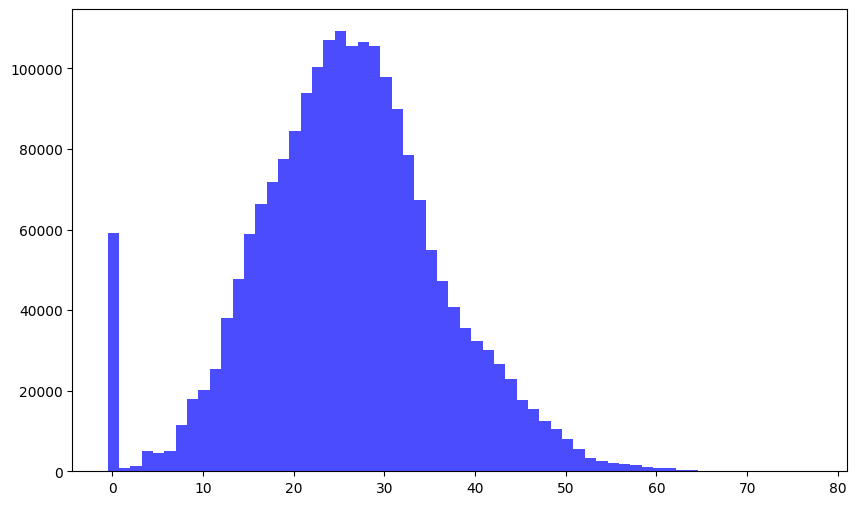

In [11]:
sensor_data_matrix_histogram = sensor_data_matrix.flatten()

plt.figure(figsize=(10, 6))
plt.hist(sensor_data_matrix_histogram, bins = bins, color = 'blue', alpha = 0.7)
#plt.title('2018 metų laiko eilutė')
plt.show()

In [34]:
import statsmodels.api as sm

In [ ]:
# Detrend each sensor's speed data (subtract linear trend)
residuals = np.zeros_like(sensor_data_matrix)
for sensor in range(speed_matrix.shape[1]):
    X = sm.add_constant(np.arange(8758))  # Hours as predictor
    model = sm.OLS(speed_matrix[:, sensor], X).fit()
    residuals[:, sensor] = model.resid  # Store residuals

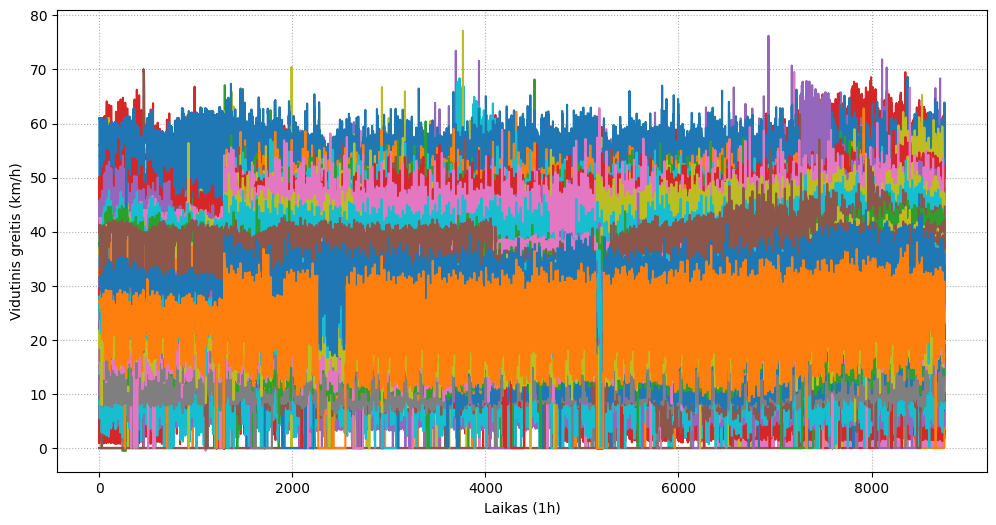

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(sensor_data_matrix)
plt.grid(linestyle=':')
plt.xlabel('Laikas (1h)')
plt.ylabel('Vidutinis greitis (km/h)')
#plt.title('2018 metų laiko eilutė')
plt.show()

In [5]:
#remove nan values
sensor_data_matrix = np.nan_to_num(sensor_data_matrix, nan=0)

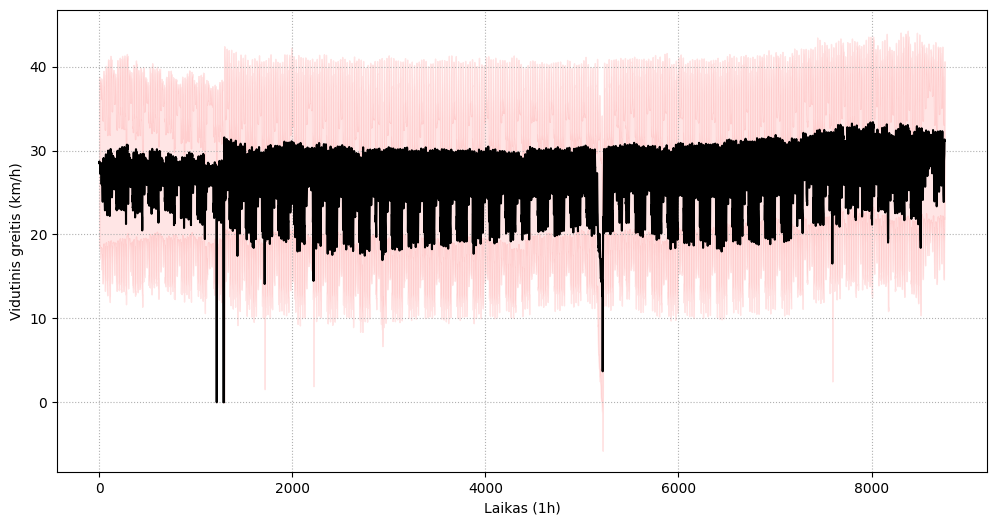

In [7]:
mean_speeds = sensor_data_matrix.mean(axis=1)
std = sensor_data_matrix.std(axis=1)

plt.figure(figsize=(12, 6))
plt.plot(mean_speeds, 'k-')
plt.fill_between(np.arange(sensor_data_matrix.shape[0]), mean_speeds - std, mean_speeds + std, color='r', alpha=0.1)
plt.grid(linestyle=':')
plt.xlabel('Laikas (1h)')
plt.ylabel('Vidutinis greitis (km/h)')
plt.show()

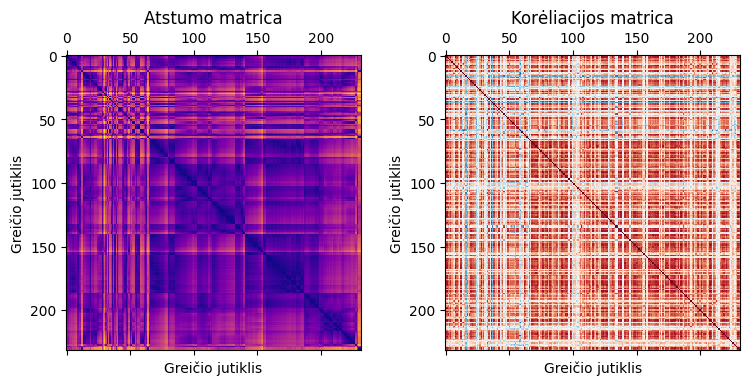

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(distance_matrix, cmap = 'plasma')
ax1.set_xlabel('Greičio jutiklis')
ax1.set_ylabel('Greičio jutiklis')
ax1.title.set_text('Atstumo matrica')
ax2.matshow(-np.corrcoef(sensor_data_matrix.T), cmap='RdBu')
ax2.set_xlabel('Greičio jutiklis')
ax2.set_ylabel('Greičio jutiklis')
ax2.title.set_text('Korėliacijos matrica')

<Figure size 800x800 with 0 Axes>

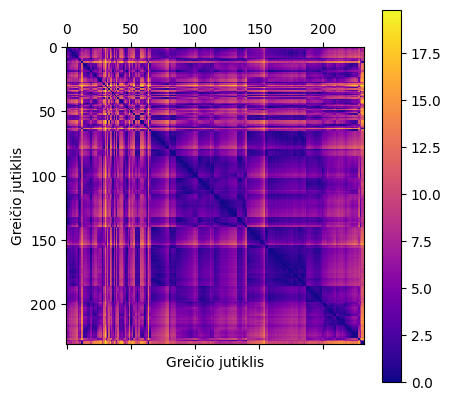

In [56]:
plt.figure(figsize=(8, 8))
ax1 = plt.matshow(distance_matrix, cmap = 'plasma')
plt.colorbar(ax1)
plt.xlabel('Greičio jutiklis')
plt.ylabel('Greičio jutiklis')
plt.show()

<Figure size 800x800 with 0 Axes>

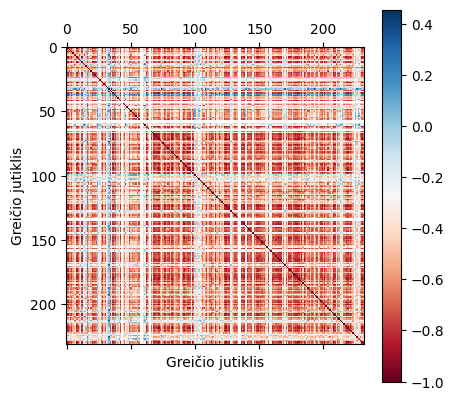

In [81]:
plt.figure(figsize=(8, 8))
ax2 = plt.matshow(-np.corrcoef(sensor_data_matrix.T), cmap='RdBu')
plt.colorbar(ax2)
plt.xlabel('Greičio jutiklis')
plt.ylabel('Greičio jutiklis')
plt.show()

In [53]:
def compute_adjacency_matrix(distance_matrix, sigma = 0.1, epsilon = 0.5):
    d = distance_matrix / 100.
    d2 = d * d
    n = distance_matrix.shape[0]
    w_mask = np.ones([n, n]) - np.identity(n)
    return np.exp(-d2 / sigma ** 2) * (np.exp(-d2 / sigma ** 2) >= epsilon) * w_mask

In [54]:
adj = compute_adjacency_matrix(distance_matrix)

Text(0, 0.5, 'Sensor station')

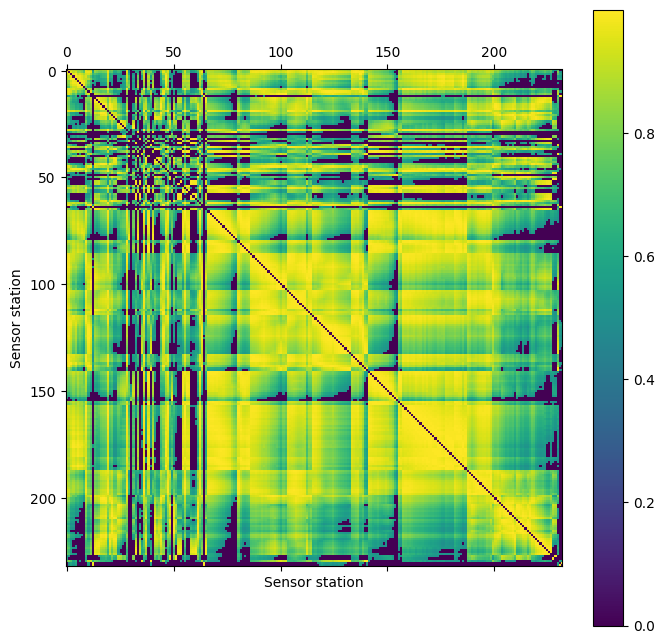

In [55]:
plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

In [60]:
def zscore(x, mean, std):
    return (x - mean) / std

In [61]:
normalized_sensor_data = zscore(sensor_data_matrix, sensor_data_matrix.mean(), sensor_data_matrix.std())

In [62]:
smoothed_sensor_data = pd.DataFrame(normalized_sensor_data).ewm(span=5, adjust=False).mean().to_numpy()

In [63]:
train_data = smoothed_sensor_data[:int(sensor_data_matrix.shape[0]*0.8)].T
test_data = smoothed_sensor_data[int(sensor_data_matrix.shape[0]*0.8):].T

In [64]:
train_data.shape, test_data.shape

((232, 7006), (232, 1752))

In [65]:
sequence_length = 24 # 24hour length sequence
prediuction_length = 6 # 6hour prediction length

def build_features_labels(sequence_len, prediction_len, train_data, test_data):
    X_train, Y_train, X_test, Y_test = [], [], [], []

    for i in range(train_data.shape[1] - int(sequence_len + prediction_len - 1)):
        a = train_data[:, i : i + sequence_len + prediction_len]
        X_train.append(a[:, :sequence_len])
        Y_train.append(a[:, sequence_len:sequence_len+prediction_len])

    for i in range(test_data.shape[1] - int(sequence_len + prediction_len - 1)):
        b = test_data[:, i : i + sequence_len + prediction_len]
        X_test.append(b[:, :sequence_len])
        Y_test.append(b[:, sequence_len:sequence_len+prediction_len])

    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)

    return X_train, Y_train, X_test, Y_test

In [66]:
X_train, Y_train, X_test, Y_test = build_features_labels(sequence_length, prediuction_length, train_data, test_data)

X_train_shape = X_train.shape
X_test_shape = X_test.shape
Y_train_shape = Y_train.shape
Y_test_shape = Y_test.shape


X_train = X_train.reshape(X_train_shape[0], X_train_shape[1], 1, X_train_shape[2])
X_test = X_test.reshape(X_test_shape[0], X_test_shape[1], 1, X_test_shape[2])
Y_test = Y_test.reshape(Y_test_shape[0], Y_test_shape[1], Y_test_shape[2])
Y_train = Y_train.reshape(Y_train_shape[0], Y_train_shape[1],Y_train_shape[2])


print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(6977, 232, 1, 24)
(6977, 232, 6)
(1723, 232, 1, 24)
(1723, 232, 6)


In [67]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

edges = np.nonzero(adj)
edges = np.vstack([edges, adj[edges]])
edge_index = edges[:2, :].astype(float)
edge_attr = edges[2, :].astype(float)
print('Edges shape: ', edge_index.shape, ', Attr shape: ',edge_attr.shape)

edge_index = torch.from_numpy(edge_index).type(torch.long).to(device)

Edges shape:  (2, 46072) , Attr shape:  (46072,)


dataloader

In [68]:
batch_size = 32

train_input = np.array(X_train)
train_target = np.array(Y_train)
train_x_tensor = torch.from_numpy(train_input).type(torch.FloatTensor).to(device)
train_target_tensor = torch.from_numpy(train_target).type(torch.FloatTensor).to(device)
train_dataset_new = torch.utils.data.TensorDataset(train_x_tensor, train_target_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset_new, batch_size=batch_size, drop_last=True)

test_input = np.array(X_test)
test_target = np.array(Y_test)
test_x_tensor = torch.from_numpy(test_input).type(torch.FloatTensor).to(device)
test_target_tensor = torch.from_numpy(test_target).type(torch.FloatTensor).to(device)
test_dataset_new = torch.utils.data.TensorDataset(test_x_tensor, test_target_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset_new, batch_size=batch_size, drop_last=True)

In [ ]:
#alternative
#train_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_train, Y_train)
#test_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_test, Y_test)
#val_loader = StaticGraphTemporalSignal(edge_index, edge_attr, X_val, Y_val)

In [69]:
class A3TGCNModel(torch.nn.Module):
  def __init__(self, node_features, periods, batch_size):
    super(A3TGCNModel, self).__init__()

    self.tgnn = A3TGCN2(in_channels=node_features, out_channels=32, periods=periods, batch_size=batch_size)
    self.linear = torch.nn.Linear(32, periods)

  def forward(self, x, edge_index):
    """
    x = Node features for T time steps
    edge_index = Graph edge indices
    """
    h = self.tgnn(x, edge_index).relu()
    h = self.linear(h)
    return h

In [94]:
epoch_count = 50
loss_fn = torch.nn.MSELoss()

model = A3TGCNModel(node_features=1, periods=6, batch_size=batch_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

train_losses = []

for epoch in range(epoch_count):
  model.train()
  print(f'Epoch {epoch+1}\n-------------------------------')

  losses = []
  for x, y in train_loader:
    y_hat = model(x, edge_index)
    loss = loss_fn(y_hat, y)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    losses.append(loss.item())

  mean_loss = sum(losses)/len(losses)
  print("Train MSE: {:.4f}\n".format(mean_loss))
  train_losses.append(np.mean(losses))

Epoch 1
-------------------------------
Train MSE: 0.8620

Epoch 2
-------------------------------
Train MSE: 0.8587

Epoch 3
-------------------------------
Train MSE: 0.8564

Epoch 4
-------------------------------
Train MSE: 0.8552

Epoch 5
-------------------------------
Train MSE: 0.8544

Epoch 6
-------------------------------
Train MSE: 0.8538

Epoch 7
-------------------------------
Train MSE: 0.8530

Epoch 8
-------------------------------
Train MSE: 0.8532

Epoch 9
-------------------------------
Train MSE: 0.8529

Epoch 10
-------------------------------
Train MSE: 0.8527

Epoch 11
-------------------------------
Train MSE: 0.8527

Epoch 12
-------------------------------
Train MSE: 0.8527

Epoch 13
-------------------------------
Train MSE: 0.8527

Epoch 14
-------------------------------
Train MSE: 0.8527

Epoch 15
-------------------------------
Train MSE: 0.8527

Epoch 16
-------------------------------
Train MSE: 0.8526

Epoch 17
-------------------------------
Train MS

In [71]:
def inverse_zscore(x, mean, std):
  return x * std + mean

In [95]:
model.eval()

y_preds = list()
y_true = list()

for x, y in test_loader:
  y = y.cpu().numpy().reshape(-1)
  y = inverse_zscore(y, sensor_data_matrix.mean(), sensor_data_matrix.std())

  y_pred = model(x, edge_index).view(len(x), -1).cpu().detach().numpy().reshape(-1)
  y_pred = inverse_zscore(y_pred, sensor_data_matrix.mean(), sensor_data_matrix.std())

  y_preds.extend(list(y_pred))
  y_true.extend(list(y))

y_preds = np.array(y_preds)
y_true = np.array(y_true)

y_preds = y_preds.reshape(int(y_preds.shape[0]/(232 * 6)), 232, 6)
y_true = y_true.reshape(int(y_true.shape[0]/(232 * 6)), 232, 6)

In [96]:
y_preds.shape, y_true.shape

((1696, 232, 6), (1696, 232, 6))

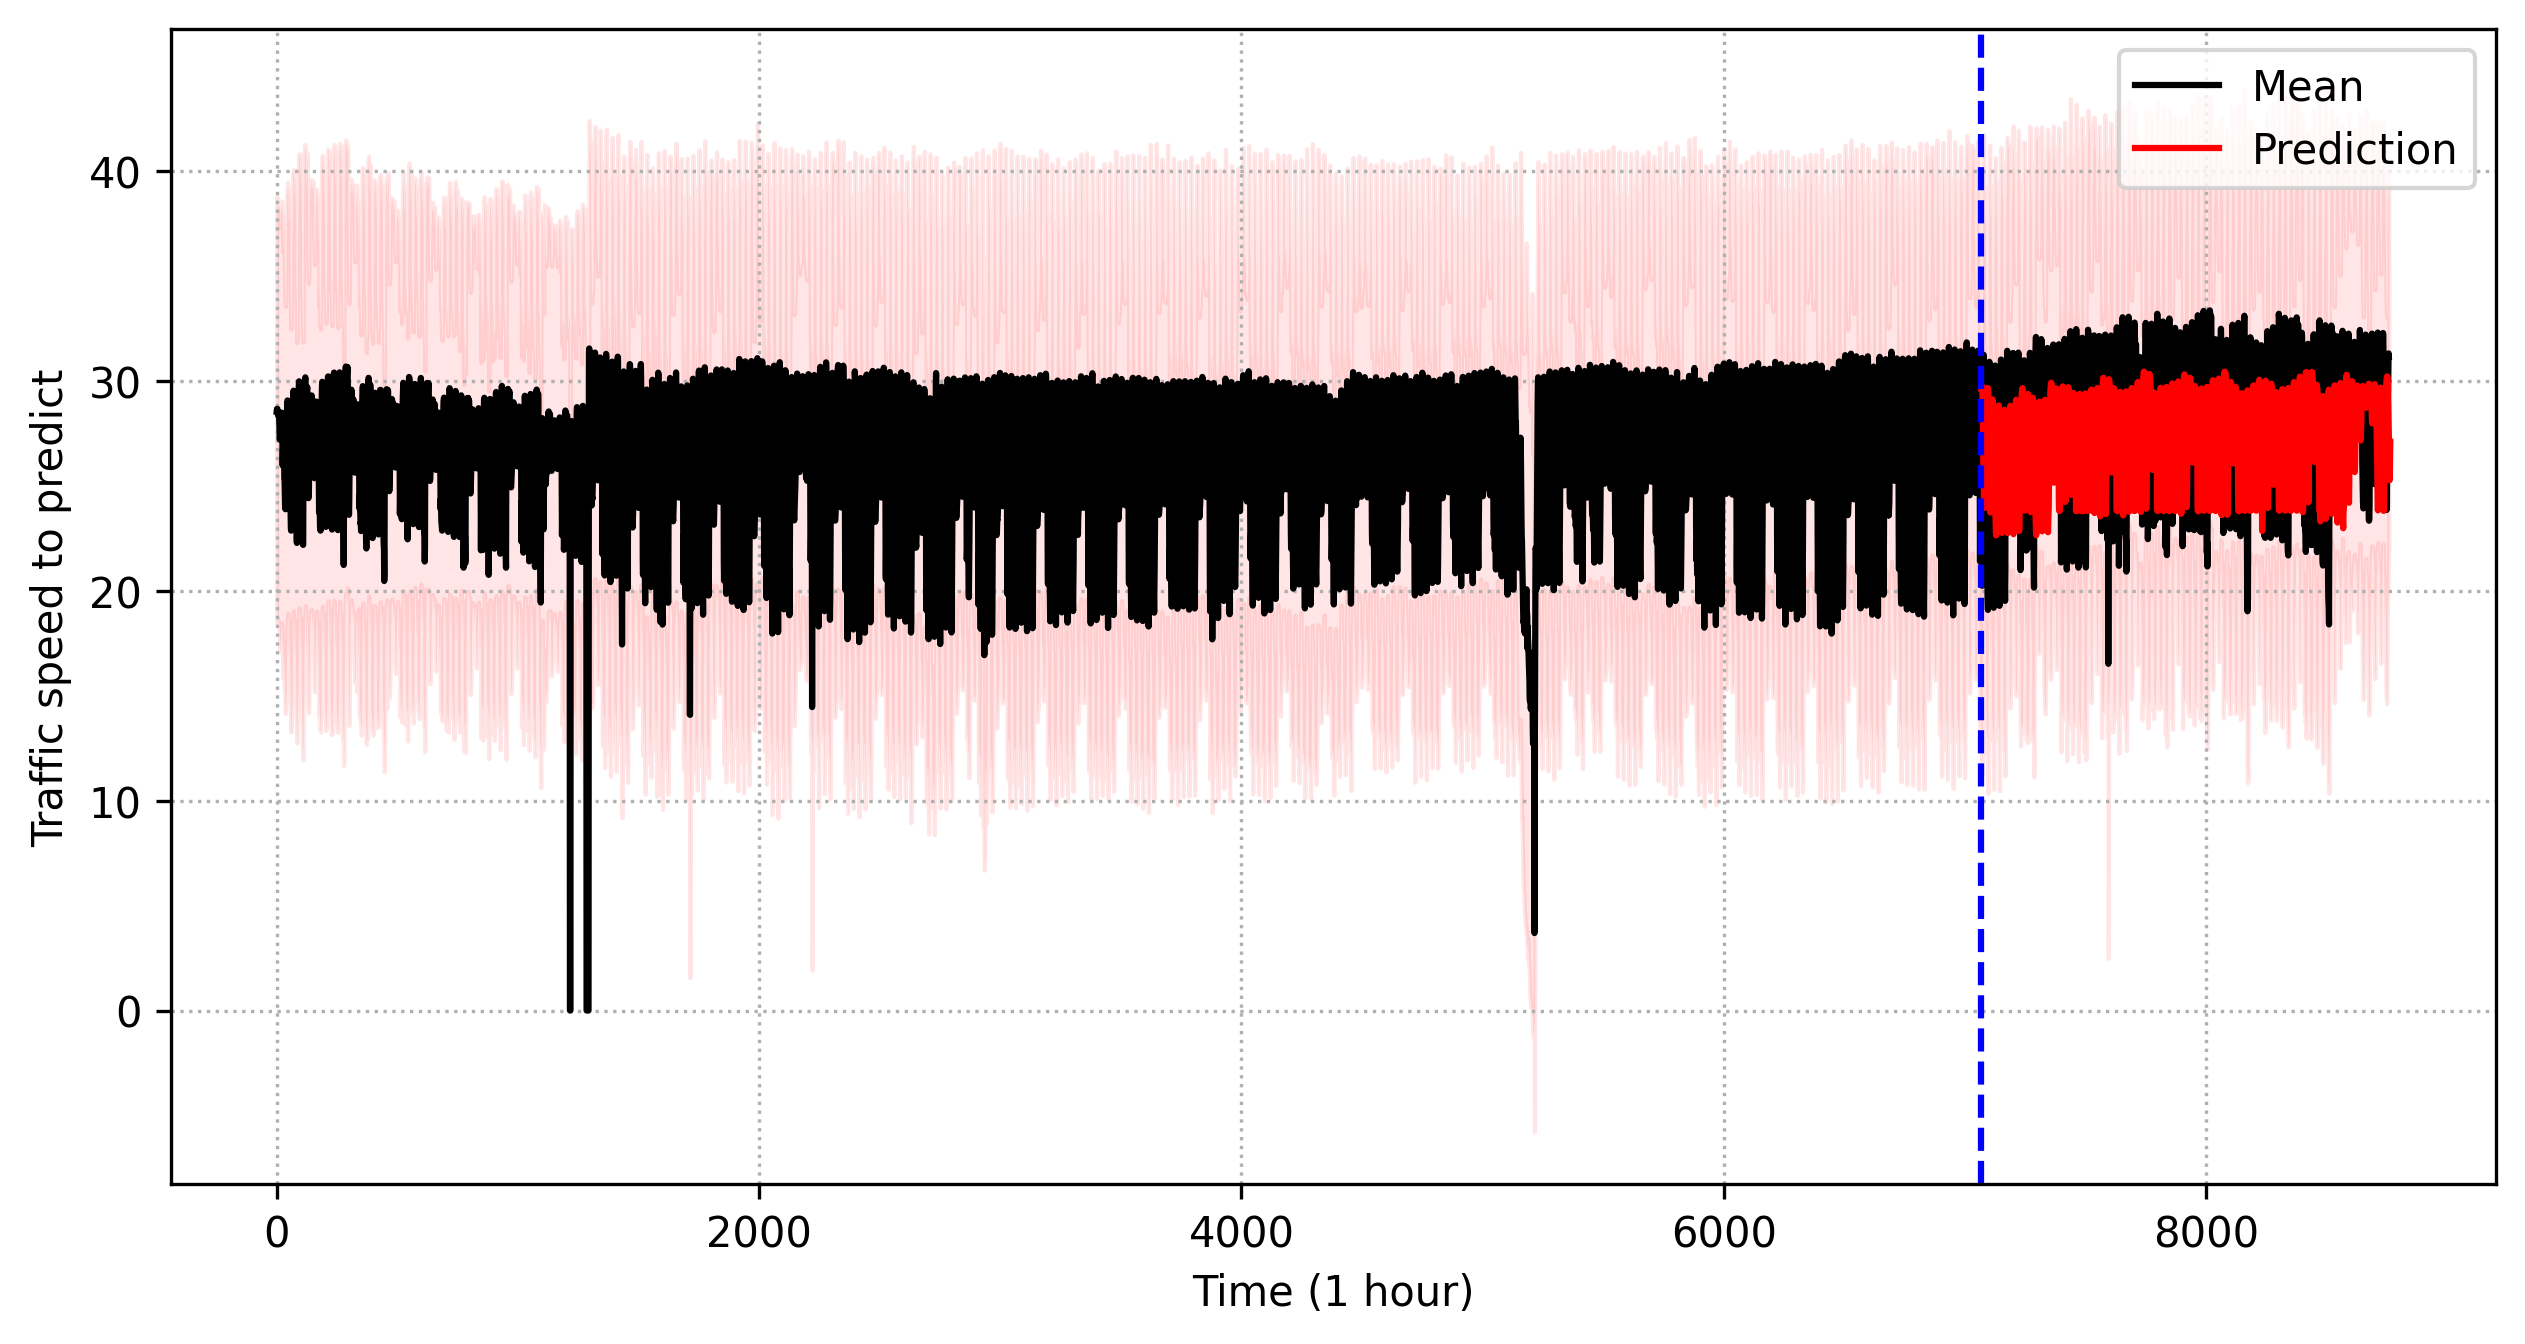

In [97]:
plt.figure(figsize=(10,5), dpi=300)
plt.plot(mean_speeds, 'k-', label='Mean')

pred_start = len(sensor_data_matrix) - len(y_preds) + 6

plt.plot(range(pred_start, pred_start + len(y_preds)), y_preds[:, :, 5].mean(axis=1), 'r-', label='Prediction')

plt.grid(linestyle=':')
plt.fill_between(np.arange(sensor_data_matrix.shape[0]), mean_speeds - std, mean_speeds + std, color='r', alpha=0.1)

plt.axvline(x=pred_start, color='b', linestyle='--')

plt.xlabel('Time (1 hour)')
plt.ylabel('Traffic speed to predict')
plt.legend(loc='upper right')

In [98]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true +=  1e-18 #add small values to true velocities to avoid division by zeros
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [99]:
print('RMSE: ', np.sqrt(mean_squared_error(y_true.flatten(), y_preds.flatten())))
print('MAE: ', mean_absolute_error(y_true.flatten(), y_preds.flatten()))
print('MAPE: ', mean_absolute_percentage_error(y_true.flatten(), y_preds.flatten()), "%")

RMSE:  9.658814321219602
MAE:  7.442094326019287
MAPE:  5.711697692065792e+17 %


In [ ]:
PATH = "epoch_30_model_no_batches.pt"

torch.save(model.state_dict(), PATH)
